# **Sinirsel Stil Aktarımı**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Sinirsel Stil Aktarımı/Data/"

hedef10.jpg  hedef20.jpg  hedef30.jpg	  referans11.jpg  referans22.jpg
hedef11.jpg  hedef21.jpg  hedef31.jpeg	  referans12.jpg  referans2.jpg
hedef12.jpg  hedef22.jpg  hedef32.jpeg	  referans13.jpg  referans3.jpg
hedef13.jpg  hedef23.jpg  hedef3.jpg	  referans14.jpg  referans4.jpg
hedef14.jpg  hedef24.jpg  hedef4.jpg	  referans15.jpg  referans5.jpg
hedef15.jpg  hedef25.jpg  hedef5.jpg	  referans16.jpg  referans6.jpg
hedef16.jpg  hedef26.jpg  hedef6.jpg	  referans17.jpg  referans7.jpg
hedef17.jpg  hedef27.jpg  hedef7.jpg	  referans18.jpg  referans8.jpg
hedef18.jpg  hedef28.jpg  hedef8.jpg	  referans19.jpg  referans9.jpg
hedef19.jpg  hedef29.jpg  hedef9.jpg	  referans20.jpg
hedef1.jpg   hedef2.jpg   referans10.jpg  referans21.jpg


In [ ]:
import time
import numpy as np
import tensorflow as tf

from datetime import datetime
from IPython.display import Image

from tensorflow import keras
from tensorflow.keras.applications import vgg19

## **1. Değişkenlerin Tanımlanması**

*   **target_image_path:** Hedef görüntü yolu
*   **style_reference_image_path:** Stil referans görüntü yolu
*   **result_prefix:** Sonuç ön eki



In [ ]:
target_image_path = "/content/drive/My Drive/Colab Notebooks/Sinirsel Stil Aktarımı/Data/hedef30.jpg"
style_reference_image_path = "/content/drive/My Drive/Colab Notebooks/Sinirsel Stil Aktarımı/Data/referans4.jpg"
result_prefix = "my_result"

## **2. Oluşturulan Resmin Boyutları**

İşlem görecek olan resimlerin aynı boyutta olması için **400px** şeklinde yeniden boyutlandırıyoruz. Çünkü farklı boyutlarda olması stil aktarımını zorlaştırmaktadır. Burada da **target_image_path** olarak adlandırdığımız hedef resmimizin bozulmadan yeniden boyutlandırılması için kendi boyutlarını kullanarak **400px** boyutuna getiriyoruz.

*   **width:** Genişlik
*   **height:** Yükseklik
*   **load_img** ile görseli yüklüyoruz.
*   Yüklenen görselin boyutlarını **size** ile alıyoruz.



In [ ]:
width, height = keras.preprocessing.image.load_img(target_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## **3. Hedef ve Referans Resimlere Göz Atmak**



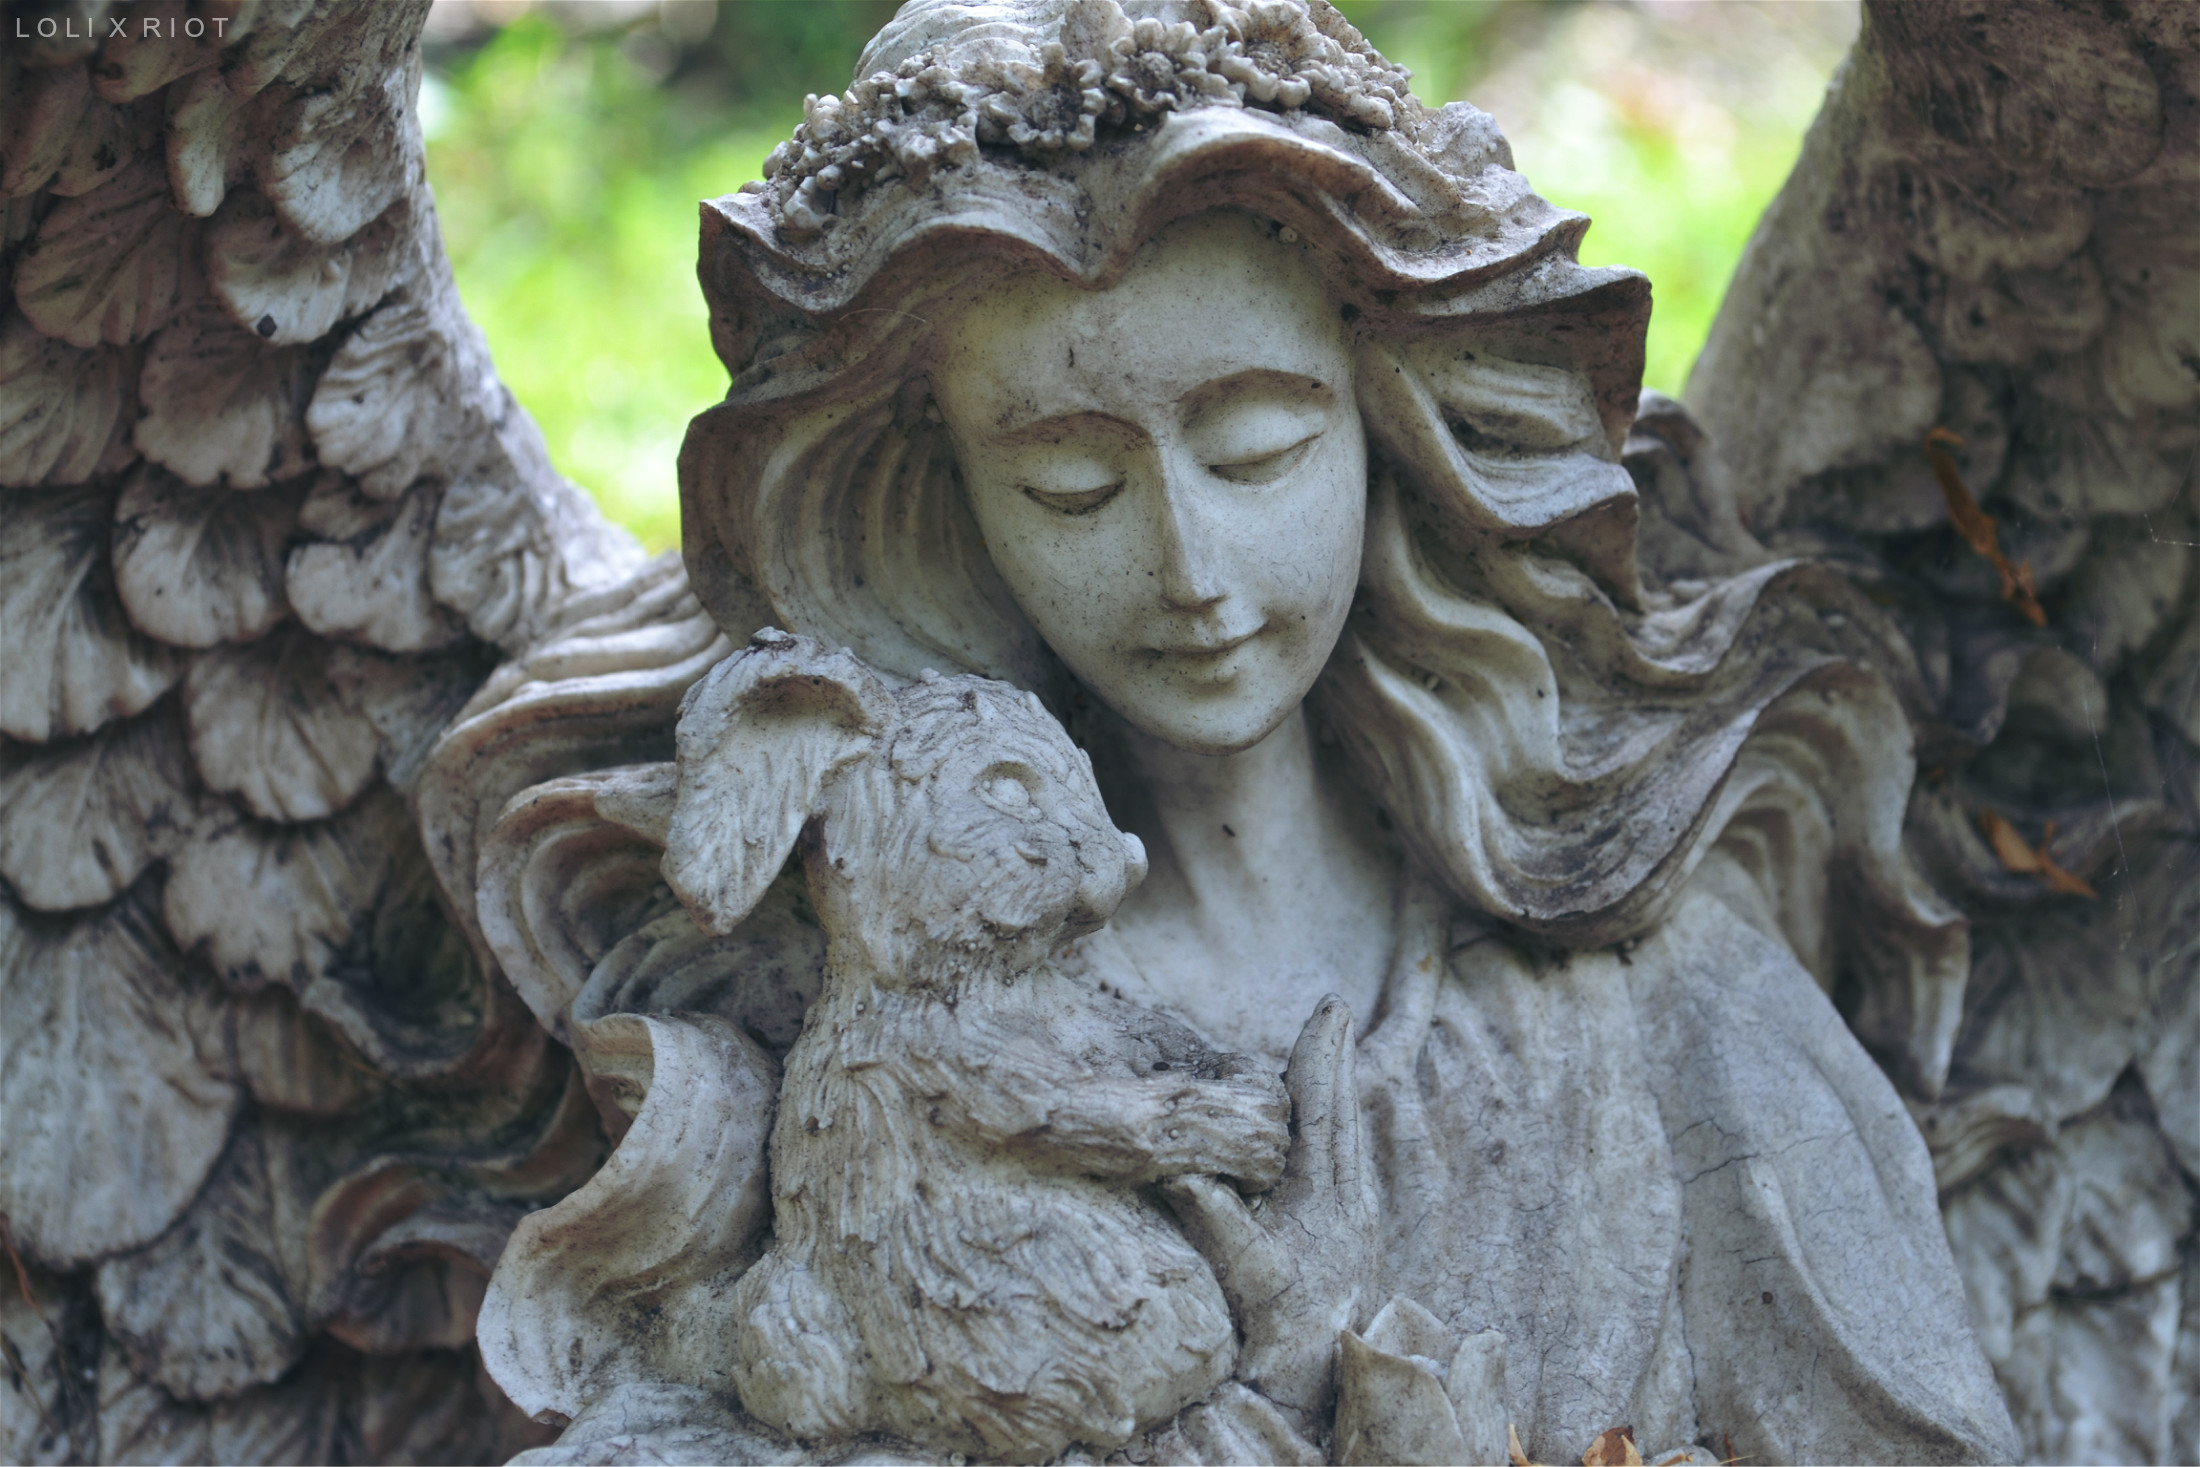

In [ ]:
Image(target_image_path)

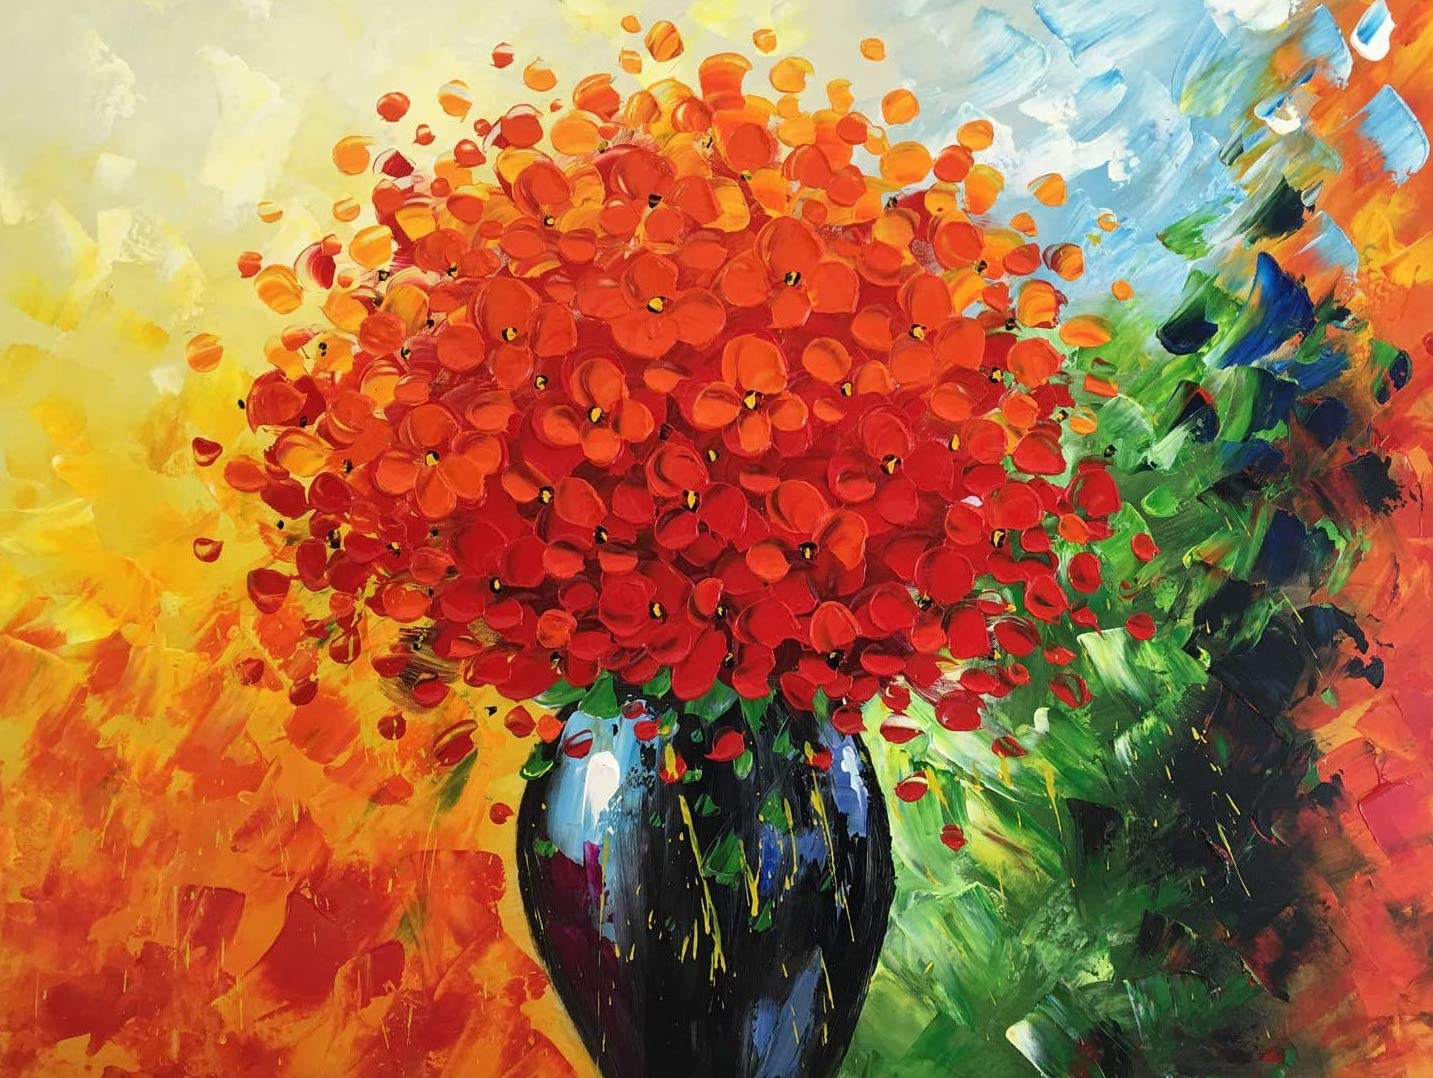

In [ ]:
Image(style_reference_image_path)


## **4. Görüntü Ön İşleme ve Görüntü Ön İşleme Kaldırma**

**VGG19** ağını kullanacağız ve bu ağa giden gelen resimlere görüntü ön işleme ve görüntü ön işlemeyi kaldırmak için işlemler uygulamamız gerekiyor. Bunlar için iki tane yardımcı fonksiyonlar oluşturacağız.

* **Görüntü Ön İşleme:**
    * Belirlediğimiz boyutlara göre **load_img** ile görseli yüklüyoruz.
    * **img_to_array** ile görseli sayılarla ifade ediyoruz.
    * **np.expand_dims** ile yeni bir katman ekliyoruz.
    * **vgg19.preprocess_input** ile ön işlemleri gerçekleştiriyoruz.
    * **tf.convert_to_tensor** ile tensöre dönüştürülmüş görseli döndürüyoruz.

In [ ]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

* **Görüntü Ön İşlemeyi Kaldırmak:**
    * **VGG19** evrişimli sinir ağı modeli **ImageNet** veri seti eğitilmiştir.
    * Görseli belirlediğimiz parametrelerle yeniden boyutlandırarak üç katmanlı hale getiriyoruz.
    * Biz de burada ImageNet verisetinin ortalamasını çıkarıp sıfır merkezli hale getiriyoruz.
    * Bu sayede **vgg19.preprocess_input**'un yaptıkları geri alınacak.
    * Yine resmi **BGR**'den **RGB**'ye dönüştürerek **vgg19.preprocess_input**'un yaptıklarını geri alıyoruz.

In [ ]:
def deprocess_image(x):
    # Bir tensörü geçerli bir görüntüye dönüştürmek için kullanım işlevi
    x = x.reshape((img_nrows, img_ncols, 3))
    # Ortalama piksele göre sıfır merkezini kaldır
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # "BGR" -> "RGB"
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## **5. Stil Kaybı**

Stil aktarım kaybını hesaplamak için 4 tane fonksiyon oluşturuyoruz.

* **Gram_Matrix:**
    * Stil kaybını hesaplamak için kullanılır.
    * Korelasyonlardan oluşmaktadır.
    * Bu da korelasyonlara bakarak hatanın minimize edilmesine yardımcı olacaktır.

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

* **Style_Loss:**
    * Stil kaybı, oluşturulan görüntüdeki referans görüntünün stilini korumak için tasarlanmıştır.
    * Yani oluşturulan görüntüyü stil referans görüntüsünün yerel dokularına yakın tutmaktadır.
    * Stil referans görüntüsünden ve oluşturulan görüntüden özellik haritalarının (stil yakalayan) gram matrislerine dayanır.
    * Burada stil görüntüsünün özniteliklerini daha ayrıntılı giriyoruz.
    * Tarz aktarımı yapacağımız için daha çok ve daha derin özniteliklere ihtiyaç vardır.
    *  S ve C olmak üzere hedef ve referans görüntülerinin gram matrislerini hesaplıyoruz.

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

* **Content_Loss:**
    * Görüntüdeki temel görüntünün "içeriğini" korumak için tasarlanmış bir yardımcı kayıp işlevidir.
    * Yani oluşturulan görüntünün üst düzey temsilini temel görüntününkine yakın tutmaktadır.

In [ ]:
def content_loss(target, combination):
    return tf.reduce_sum(tf.square(combination - target))

* **Total_Variation_Loss:**
    * Toplam varyasyon kaybı, oluşturulan görüntüyü yerel olarak tutarlı tutmak için tasarlanmıştır.
    * **gram_matrix** ve **style_loss** ek olarak üçüncü bir kayıp olarak eklenir.
    * Üretilen resmin uzamsal olarak devamlılığını kontrol edecektir.
    * Görüntü noktalarının çok büyük kayıp değerleri almasını da engelleyecektir.
    * Burada **alpha** ve **beta** değerlerimiz vardır.
    * İçerik ve stillerin yeniden yapılandırılması için kullanılacak ağırlık faktörleridir.

In [ ]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## **6. VGG19 Model**

* Önceden eğitilmiş ImageNet ağırlıklarıyla yüklenmiş bir VGG19 modeli yüklüyoruz.

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

## **7. Farklı Kayıp Bileşenlerini Tanımlamak**

* Hedef ve referans görüntüler için parametreler belirliyoruz.
* İlk olarak toplam varyasyon ağırlığını giriyoruz.
* Ardından da giriş ve referans ağırlıklarını giriyoruz.
* Referans ve hedef görüntülerine bağlı olarak içerik kaybının toplam kayba katkısı olan **content_weight** katsayısını ayarlayabilirsiniz.
* Yüksek **content_weight** değerleri hedef resmin üretilen resimde daha çok tanınabilir hale gelmesi anlamına gelecektir.

In [ ]:
total_variation_weight = 1e-6
content_weight = 2.5e-8
style_weight = 1e-6

## **8. En Küçültülecek Kaybı Tanımlamak**

* En küçülteceğimiz kayıp, oluşturduğumuz üç kaybın ağırlıklı ortalaması olacaktır.
* İçerik kaybı için üst katmanlardan birisi olan **block5_conv2** kullanıyoruz.
* Stil kaybı için hem ilk katmanlardan hem de üst katmanlardan birkaç katmanı içeren bir liste kullanıyoruz.
* Toplam kaybı da en sona ekliyoruz.

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

* **VGG19**'da her katman için aktivasyon değerlerini döndüren bir model kuruyoruz.

In [ ]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

* **Stil kaybı** için kullanılacak katmanların listesini ve **içerik kaybı** için kullanılacak olan katmanı giriyoruz.

In [ ]:
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

* Toplam değişim kaybını verecek olan fonksiyonu oluşturuyoruz.

In [ ]:
def compute_loss(combination_image, target_image, style_reference_image):
    input_tensor = tf.concat([target_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Kaybı başlat
    loss = tf.zeros(shape=())

    # İçerik kaybı ekle
    layer_features = features[content_layer_name]
    target_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(target_image_features, combination_features)
    
    # Stil kaybı ekle
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Toplam varyasyon kaybı ekle
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## **9. Gradyan İniş Sürecini Oluşturmak**

* Gradyan iniş sürecini oluşturuyoruz.
* **Kayıp** ve **gradyan** hesaplamasına bir **tf.function** dekoratörü ekliyoruz.
* Bunu derleme işini daha hızlı hale getirmek için yapıyoruz.
* Kayıp ve gradyan değerlerini ayrı ayrı hesaplamak birçok gereksiz hesaplamaya neden olacaktır ve işlem süreci çok fazla yavaşlayacaktır. Bu sebeple ikisini beraber hesaplıyoruz.

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, target_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, target_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## **10. Stil Aktarımı Döngüsü**

* Kaybı en aza indirmek için gradyan iniş adımlarını tekrar tekrar çalıştırıyoruz ve elde edilen görüntüyü her 100 yinelemede bir kaydediyoruz.
* Bu sayede her 100 adımda öğrenme oranını 0,96 azaltıyoruz.

In [ ]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))
target_image = preprocess_image(target_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(target_image_path))

iterations = 4000
start_time_ = datetime.now()

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, target_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
  
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
    
time_elapsed = datetime.now() - start_time_
print(f"Time elapsed: {time_elapsed}")

Iteration 100: loss=3889.45
Iteration 200: loss=3253.62
Iteration 300: loss=2972.12
Iteration 400: loss=2798.30
Iteration 500: loss=2674.71
Iteration 600: loss=2580.82
Iteration 700: loss=2506.04
Iteration 800: loss=2444.57
Iteration 900: loss=2392.83
Iteration 1000: loss=2348.38
Iteration 1100: loss=2309.70
Iteration 1200: loss=2275.57
Iteration 1300: loss=2245.24
Iteration 1400: loss=2218.01
Iteration 1500: loss=2193.44
Iteration 1600: loss=2171.22
Iteration 1700: loss=2150.95
Iteration 1800: loss=2132.40
Iteration 1900: loss=2115.32
Iteration 2000: loss=2099.56
Iteration 2100: loss=2085.00
Iteration 2200: loss=2071.47
Iteration 2300: loss=2058.88
Iteration 2400: loss=2047.16
Iteration 2500: loss=2036.22
Iteration 2600: loss=2026.00
Iteration 2700: loss=2016.43
Iteration 2800: loss=2007.44
Iteration 2900: loss=1999.00
Iteration 3000: loss=1991.07
Iteration 3100: loss=1983.60
Iteration 3200: loss=1976.55
Iteration 3300: loss=1969.90
Iteration 3400: loss=1963.61
Iteration 3500: loss=19

* 4000 iterasyon sonucu elde edilen görüntü:

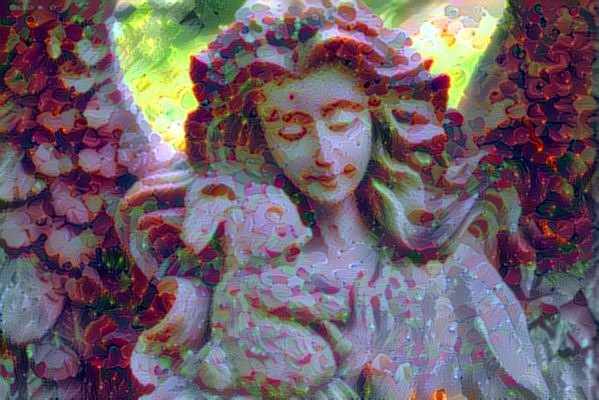

In [ ]:
Image(result_prefix + "_at_iteration_4000.png")